In [108]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, confusion_matrix, roc_auc_score, RocCurveDisplay, auc
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

To Do List: 

1. Compare model with and without the cycle indicator using both Penalized Logistic Regression and Gradient Boosting 
2. Metrics used for Model Comparison: ROC and AUC

# Functions

In [8]:
def get_numpy_data(dataframe, features, label):
    features_matrix = dataframe[features].to_numpy()
    label_array = dataframe[label].to_numpy()
    return(features_matrix, label_array)

In [132]:
def data_import(file_path, list_to_drop, test_size, random_state):
    
    data = pd.read_csv(file_path).drop(list_to_drop, axis = 1)
    data["spread_derivative"] = pd.to_numeric(data["spread_derivative"], errors = "coerce")
    data.replace([np.inf, -np.inf], np.nan, inplace = True)
    data = data.dropna()
    
    feature_list = data.columns.to_list()
    feature_list.remove("custom_recession_data")
    recession_label = "custom_recession_data"
    
    feature_matrix, label_array = get_numpy_data(data, feature_list, recession_label)
    x_train, x_test, y_train, y_test = train_test_split(features_matrix, label_array, test_size = test_size, random_state = random_state)
    return x_train, x_test, y_train, y_test
    

# Data Import

1. Recession Data with Volatility Index and Cycle Indicator (Vix/Spread)

In [134]:
file_path = "updated_final_data.csv"
columns_to_drop = ["Unnamed: 0", "date", "usrecd", "m1sl", "m2sl", "icsa", "mabmm301usm189s",  "bogmbase", "volume", "adj close"]
test_size = 0.3
random_state = 11

x_train_vix, x_test_vix, y_train_vix, y_test_vix = data_import(file_path, columns_to_drop, test_size, random_state)

2. Recession Data without Volatility Index and Cycle Indicator (Vix/Spread)

In [135]:
file_path = "updated_final_data.csv"
columns_to_drop = ["Unnamed: 0", "date", "usrecd", "m1sl", "m2sl", "icsa", "mabmm301usm189s",  "bogmbase", "volume", "adj close", "cycle_indicator", "final_vol"]
test_size = 0.3
random_state = 11

x_train, x_test, y_train, y_test = data_import(file_path, columns_to_drop, test_size, random_state)

# Logistic Regression with L2 Penalty

In [140]:
from sklearn.preprocessing import PolynomialFeatures, QuantileTransformer, StandardScaler
from sklearn.pipeline import Pipeline as pipe
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, make_scorer


In [141]:
# Logistic Regression Pipe
lr_pipe = pipe([
    ("scale", StandardScaler()),
    ("polynomial", PolynomialFeatures(1)),
    ("model", LogisticRegression(random_state = 11))
])

In [156]:
# Logistic Regression Grid Search
lr_param_grid = [{'model__penalty': ['l1', 'l2'],
                   "model__C": [0.00001, 0.0001, 0.001, 0.01, 0.1, 1],
                   'model__solver': ['liblinear']}]

In [157]:
# Grid Search
lr_grid_search = GridSearchCV(estimator=lr_pipe,
        param_grid=lr_param_grid,
        scoring='roc_auc',
        cv=3)

In [160]:
lr_grid_search.fit(x_train_vix, y_train_vix)
df = pd.DataFrame(lr_grid_search.cv_results_)
df

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.002882      0.000168         0.001648        0.000401   
1        0.002256      0.000367         0.000960        0.000076   
2        0.001542      0.000799         0.001389        0.000412   
3        0.001921      0.000113         0.000689        0.000489   
4        0.001924      0.000646         0.000982        0.000002   
5        0.001359      0.000466         0.001332        0.000464   
6        0.000968      0.000044         0.001005        0.000009   
7        0.000959      0.000055         0.001203        0.000274   
8        0.001590      0.000433         0.000631        0.000448   
9        0.001338      0.000470         0.000991        0.000009   
10       0.002219      0.000258         0.000645        0.000456   
11       0.003049      0.001617         0.002204        0.000574   

   param_model__C param_model__penalty param_model__solver  \
0         0.00001                   l1           liblinear   
1         0.00001                   l2           liblinear   
2          0.0001                   l1           liblinear   
3          0.0001                   l2           liblinear   
4           0.001                   l1           liblinear   
5           0.001                   l2           liblinear   
6            0.01                   l1           liblinear   
7            0.01                   l2           liblinear   
8             0.1                   l1           liblinear   
9             0.1                   l2           liblinear   
10              1                   l1           liblinear   
11              1                   l2           liblinear   

                                               params  split0_test_score  \
0   {'model__C': 1e-05, 'model__penalty': 'l1', 'm...           0.500000   
1   {'model__C': 1e-05, 'model__penalty': 'l2', 'm...           0.802041   
2   {'model__C': 0.0001, 'model__penalty': 'l1', '...           0.500000   
3   {'model__C': 0.0001, 'model__penalty': 'l2', '...           0.805442   
4   {'model__C': 0.001, 'model__penalty': 'l1', 'm...           0.500000   
5   {'model__C': 0.001, 'model__penalty': 'l2', 'm...           0.819048   
6   {'model__C': 0.01, 'model__penalty': 'l1', 'mo...           0.500000   
7   {'model__C': 0.01, 'model__penalty': 'l2', 'mo...           0.842177   
8   {'model__C': 0.1, 'model__penalty': 'l1', 'mod...           0.825170   
9   {'model__C': 0.1, 'model__penalty': 'l2', 'mod...           0.829932   
10  {'model__C': 1, 'model__penalty': 'l1', 'model...           0.840136   
11  {'model__C': 1, 'model__penalty': 'l2', 'model...           0.828571   

    split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0            0.500000           0.500000         0.500000        0.000000   
1            0.748454           0.663918         0.738137        0.056858   
2            0.500000           0.500000         0.500000        0.000000   
3            0.749141           0.668041         0.740875        0.056397   
4            0.500000           0.500000         0.500000        0.000000   
5            0.762887           0.690722         0.757552        0.052524   
6            0.500000           0.500000         0.500000        0.000000   
7            0.825430           0.817869         0.828492        0.010157   
8            0.665292           0.751890         0.747451        0.065345   
9            0.878351           0.907216         0.871833        0.031886   
10           0.928522           0.932646         0.900435        0.042671   
11           0.923024           0.927835         0.893144        0.045702   

    rank_test_score  
0                 9  
1                 8  
2                 9  
3                 7  
4                 9  
5                 5  
6                 9  
7                 4  
8                 6  
9                 3  
10                1  
11                2

Logistic Regression-Without Vix: 0.837847469707769
Logistic Regression-With Vix: 0.928367783321454
Gradient Boosting-without Vix: 0.9698859586600143
Gradient Boosting-With Vix: 0.9796863863150392


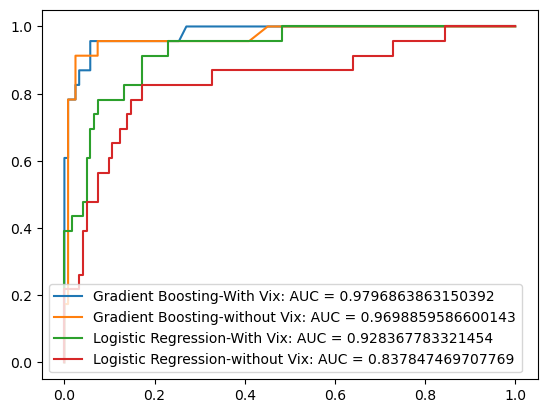

In [114]:
pipe = Pipeline([
    ("scale", StandardScaler()),
    ("polynomial", PolynomialFeatures(1)),
    ("model", LogisticRegression(class_weight = {0: 1, 1:3}, penalty = "l2", C = 0.01, solver = "liblinear", max_iter = 100))
])


prob = pipe.fit(x_train, y_train).predict_proba(x_test)
fpr, tpr, thresholds = roc_curve(y_test, prob[:, 1], pos_label=1)
auc1 = auc(fpr, tpr)

prob2 = pipe.fit(x_train1, y_train1).predict_proba(x_test1)
fpr2, tpr2, thresholds = roc_curve(y_test1, prob2[:, 1], pos_label=1)
auc2 = auc(fpr2, tpr2)

clf = GradientBoostingClassifier(n_estimators=50, learning_rate=1.0, max_depth=1, random_state=0).fit(x_train, y_train)
clf_prob = clf.predict_proba(x_test)
fpr3, tpr3, thresholds = roc_curve(y_test, clf_prob[:, 1], pos_label=1)
auc3 = auc(fpr3, tpr3)

clf1 = GradientBoostingClassifier(n_estimators=50, learning_rate=1.0, max_depth=1, random_state=0).fit(x_train1, y_train1)
clf_prob1 = clf1.predict_proba(x_test1)
fpr4, tpr4, thresholds = roc_curve(y_test1, clf_prob1[:, 1], pos_label=1)
auc4 = auc(fpr4, tpr4)

plt.figure(0).clf()
plt.plot(fpr4, tpr4, label = "Gradient Boosting-With Vix: AUC = " + str(auc4))
plt.plot(fpr3, tpr3, label = "Gradient Boosting-without Vix: AUC = " + str(auc3))
plt.plot(fpr2, tpr2, label = "Logistic Regression-With Vix: AUC = " + str(auc2))
plt.plot(fpr, tpr, label = "Logistic Regression-without Vix: AUC = " + str(auc1))
plt.legend()

print("Logistic Regression-Without Vix: " + str(auc1))
print("Logistic Regression-With Vix: " + str(auc2))
print("Gradient Boosting-without Vix: " + str(auc3))
print("Gradient Boosting-With Vix: " + str(auc4))

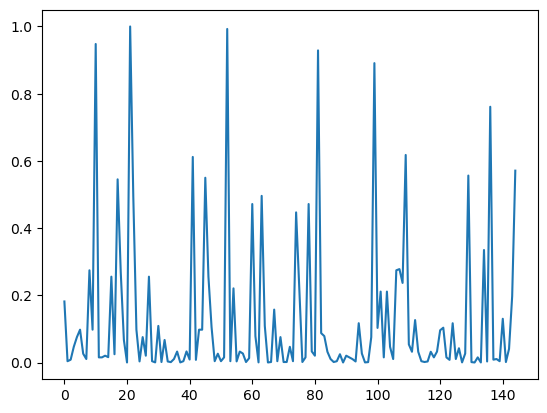

In [81]:
plt.plot(clf_prob[:,1])

In [18]:
grid = GridSearchCV(
    estimator = LogisticRegression(class_weight = {0: 1, 1: 3} , penalty = "l2", solver = "liblinear", max_iter = 100),
    param_grid = {"C": [v for v in np.linspace(0.00001, 1, 100)]},
    scoring = {'precision': make_scorer(precision_score), "recall_score": make_scorer(recall_score)},
    refit = "precision",
    cv = 4
)
grid.fit(x_train, y_train)
df = pd.DataFrame(grid.cv_results_)
df

C:\Users\peter\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\peter\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\peter\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\peter\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision 

mean_fit_time  std_fit_time  mean_score_time  std_score_time   param_C  \
0        0.001003      0.001737         0.007001        0.003174   0.00001   
1        0.004680      0.001094         0.004385        0.000682  0.010111   
2        0.002566      0.001923         0.004745        0.001132  0.020212   
3        0.003547      0.000815         0.004793        0.000727  0.030313   
4        0.000000      0.000000         0.008416        0.000488  0.040414   
..            ...           ...              ...             ...       ...   
95       0.004755      0.000892         0.003586        0.000929  0.959596   
96       0.003659      0.000915         0.004124        0.000356  0.969697   
97       0.003021      0.002656         0.004693        0.002297  0.979798   
98       0.002157      0.000805         0.005426        0.001238  0.989899   
99       0.004859      0.000961         0.004274        0.001764       1.0   

                         params  split0_test_precision  split1_test_precision  \
0                  {'C': 1e-05}               0.000000               0.000000   
1    {'C': 0.01011090909090909}               0.600000               0.583333   
2    {'C': 0.02021181818181818}               0.562500               0.500000   
3   {'C': 0.030312727272727272}               0.529412               0.437500   
4    {'C': 0.04041363636363637}               0.500000               0.437500   
..                          ...                    ...                    ...   
95    {'C': 0.9595963636363636}               0.562500               0.466667   
96    {'C': 0.9696972727272727}               0.562500               0.466667   
97    {'C': 0.9797981818181818}               0.562500               0.466667   
98    {'C': 0.9898990909090909}               0.562500               0.466667   
99                   {'C': 1.0}               0.562500               0.466667   

    split2_test_precision  split3_test_precision  mean_test_precision  \
0                0.000000               0.000000             0.000000   
1                0.692308               0.600000             0.618910   
2                0.692308               0.571429             0.581559   
3                0.692308               0.600000             0.564805   
4                0.692308               0.600000             0.557452   
..                    ...                    ...                  ...   
95               0.875000               0.437500             0.585417   
96               0.875000               0.437500             0.585417   
97               0.875000               0.437500             0.585417   
98               0.875000               0.437500             0.585417   
99               0.875000               0.437500             0.585417   

    std_test_precision  rank_test_precision  split0_test_recall_score  \
0             0.000000                  100                      0.00   
1             0.042919                    1                      0.75   
2             0.069611                   26                      0.75   
3             0.093481                   28                      0.75   
4             0.097064                   67                      0.75   
..                 ...                  ...                       ...   
95            0.173468                    2                      0.75   
96            0.173468                    2                      0.75   
97            0.173468                    2                      0.75   
98            0.173468                    2                      0.75   
99            0.173468                    2                      0.75   

    split1_test_recall_score  split2_test_recall_score  \
0                   0.000000                  0.000000   
1                   0.636364                  0.818182   
2                   0.636364                  0.818182   
3                   0.636364                  0.818182   
4                   0.636364                  0.81

# Tree Method & Gradient Boosting

In [1539]:
decision_tree = tree.DecisionTreeClassifier(criterion = "gini", max_depth = 4, splitter = "best")
rec_decison_tree = decision_tree.fit(x_train, y_train)

In [1540]:
rec_decison_tree.get_n_leaves()

14

[Text(0.58, 0.9, 'x[4] <= -0.533\ngini = 0.309\nsamples = 10033\nvalue = [8115, 1918]'),
 Text(0.32, 0.7, 'x[0] <= 0.727\ngini = 0.481\nsamples = 3361\nvalue = [2012, 1349]'),
 Text(0.16, 0.5, 'x[1] <= -1.4\ngini = 0.422\nsamples = 2664\nvalue = [1858, 806]'),
 Text(0.08, 0.3, 'x[0] <= -0.326\ngini = 0.493\nsamples = 641\nvalue = [283, 358]'),
 Text(0.04, 0.1, 'gini = 0.096\nsamples = 197\nvalue = [10, 187]'),
 Text(0.12, 0.1, 'gini = 0.474\nsamples = 444\nvalue = [273, 171]'),
 Text(0.24, 0.3, 'x[1] <= 0.571\ngini = 0.345\nsamples = 2023\nvalue = [1575, 448]'),
 Text(0.2, 0.1, 'gini = 0.292\nsamples = 1912\nvalue = [1573, 339]'),
 Text(0.28, 0.1, 'gini = 0.035\nsamples = 111\nvalue = [2, 109]'),
 Text(0.48, 0.5, 'x[0] <= 1.58\ngini = 0.344\nsamples = 697\nvalue = [154, 543]'),
 Text(0.4, 0.3, 'x[1] <= 0.567\ngini = 0.101\nsamples = 525\nvalue = [28, 497]'),
 Text(0.36, 0.1, 'gini = 0.057\nsamples = 512\nvalue = [15, 497]'),
 Text(0.44, 0.1, 'gini = 0.0\nsamples = 13\nvalue = [13, 0]')

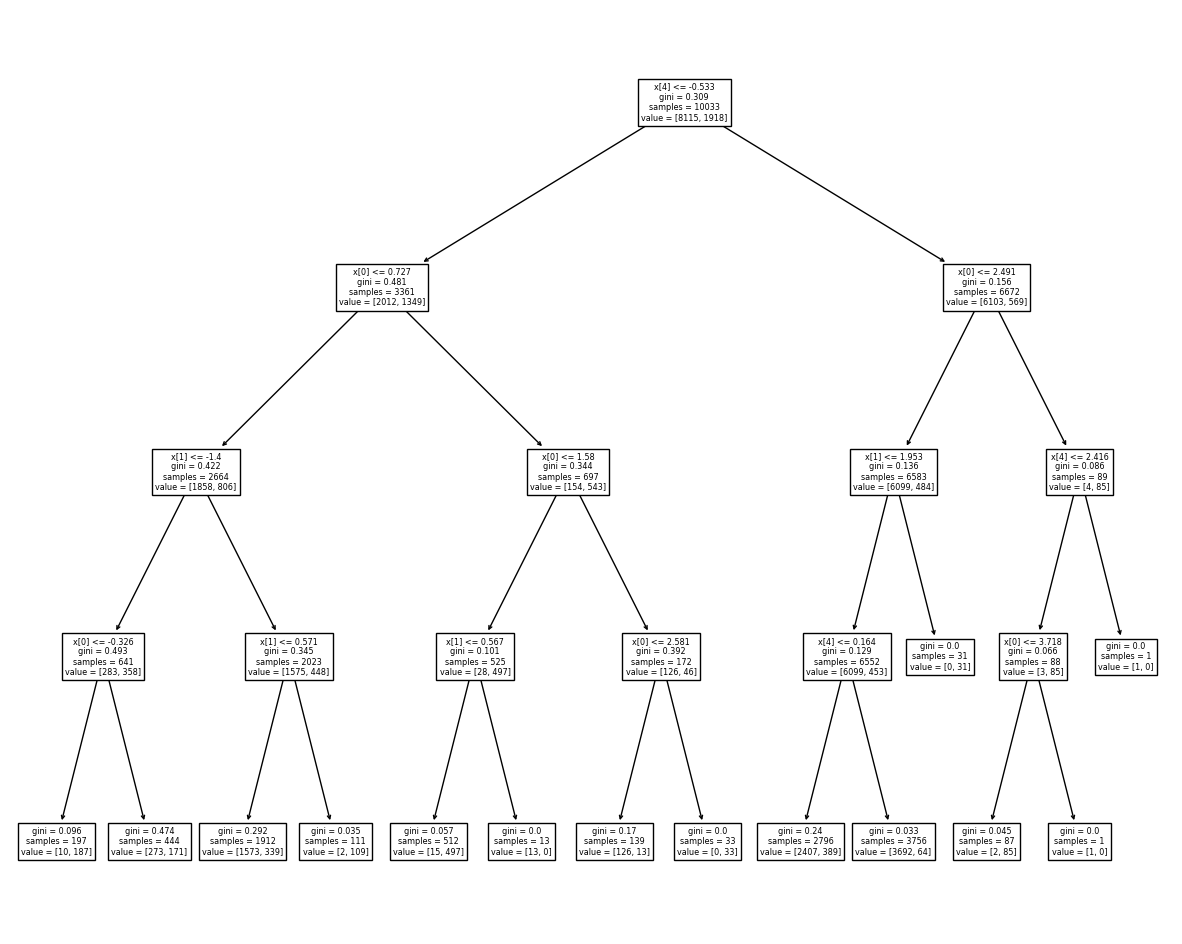

In [1541]:
plt.figure(figsize = (15,12))
tree.plot_tree(rec_decison_tree)

In [1542]:
training_prob = rec_decison_tree.predict_proba(x_train)
test_prob = rec_decison_tree.predict_proba(x_test)

In [1543]:
train_rec = prob_to_rec(training_prob, 0.633333)[:,1]
test_rec = prob_to_rec(test_prob, 0.633333)[:,1]

In [1544]:
train_correct = np.count_nonzero(train_rec == y_train)/len(y_train)
test_correct = np.count_nonzero(test_rec == y_test)/len(y_test)
print("traing set: " + str(train_correct))
print("test set: " + str(test_correct))

traing set: 0.8998305591547892
test set: 0.5905603348058591
